# Delineate basins 1-by-1
This is a working script used to delineate basins using the MERIT Hydro data (DEM, flow direction, basin discretization). CAMELS-US and RHBN metadata about station locations do not always lead to accurate basin delineation. In this script we go through the basins one by one, so that we can manually modify the outlet location in the CAMELS-spat metadata file for basins for which the original station or outlet location is not a good fit with the MERIT DEM. This also lets us add extra notes about the confidence we have in this manually moved outlet and therefore the resulting basin outline. 

In [1]:
import sys
import shutil
import warnings
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')

# MERIT Hydro data
merit_path = cs.read_from_config(config_file, 'merit_path')
merit_acc = Path(data_path) / merit_path / 'flow_accumulation_grid' / 'merit_hydro_acc.tif'
merit_dir = Path(data_path) / merit_path / 'flow_direction_grid' / 'merit_hydro_dir.tif'
merit_bas = Path(data_path) / merit_path / 'shapes' / 'basins' / 'cat_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1_hillslopes_pfaf_7_8_clean_fixed.shp'
merit_riv = Path(data_path) / merit_path / 'shapes' / 'rivers' / 'riv_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

### Data loading

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Shapefiles
basins_shp = gpd.read_file(merit_bas)
rivers_shp = gpd.read_file(merit_riv)

### Delineation

In [6]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [7]:
# Add two metadata columns we'll need
cs_meta['Ref_and_new_shape_fractional_overlap'] = 'n/a'

In [9]:
# Make sure we know the correct metadata columns
c_area, c_over = 9,18
assert (cs_meta.columns[c_area] == 'Basin_area_km2') # If these aren't true, they'll pop an error
assert (cs_meta.columns[c_over] == 'Ref_and_new_shape_fractional_overlap')

In [10]:
def delineation_loop(i):
    
    '''Delineates basin for station at index i in the CAMELS-spat metadata file'''
    
    # Input:
    # i - index in CAMELS-spat metadata file to process
    
    # 1. Prepare file paths and names
    # --------------------------------------------------------------------------------------
    basin_id, shp_lump_path, shp_dist_path, ref_path, plot_path = \
                                        cs.prepare_delineation_outputs(cs_meta, i, Path(data_path)/cs_basin_folder)
    
    # 2. Get the station or outlet location
    # --------------------------------------------------------------------------------------
    lat,lon = cs.read_delineation_coords(cs_meta,i)
    
    # 3. Delineate the basin
    # --------------------------------------------------------------------------------------
    # 3a. Subset the Geotiffs for quicker processing
    subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
    temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                                    str(merit_acc), 
                                                    str(merit_dir),
                                                    temp_dir = tmp_dir)
    grid,acc,fdir = cs.load_tifs_with_pysheds(str(temp_acc),str(temp_dir)) 
        
    # 3b. Basin extraction
    # Ignore future warnings for this part of the code to avoid FutureWarning screen spam by Shapely and Pandas
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        # Extract the full basin with pysheds
        lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path) # Saves file as part of function
        
        # Extract the MERIT Hydro basins and river network
        dist_basin, dist_river = cs.subset_merit_hydro_to_basin(basins_shp,rivers_shp,lump_basin,shp_dist_path,lat,lon) # Ditto
    
    # 4. Delineation checks
    # --------------------------------------------------------------------------------------
    # 4a. Assert shape validity
    if not all(lump_basin.is_valid): print('ERROR: Lumped shape not valid') # assert() throws SyntaxWarning over .is_valid
    if not all(dist_basin.is_valid): print('ERROR: Distributed shape not valid')
        
    # 4b. Get areas and overlap
    area_lump = (lump_basin.to_crs('ESRI:102008').area / 10**6)[0] # [km^2]
    area_dist = dist_basin['unitarea'].sum() # [km^2]
    overlap_lump = cs.calculate_basin_and_reference_overlap(lump_basin, ref_path) # Returns 'n/a' if no reference shape exists
    overlap_dist = cs.calculate_basin_and_reference_overlap(dist_basin, ref_path) # Should be identical to lumped
    
    # 4c. Visual assessment of outcomes
    ref_areas = cs.get_reference_areas(cs_meta,i) # [km^2] 
    stats = cs.prepare_plotting_stats(ref_areas,area_lump,area_dist,overlap_lump,overlap_dist) 
    cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, stats, plot_path)
    
    # 4d. Update metadata file
    cs_meta.iat[i,c_area] = area_dist
    cs_meta.iat[i,c_over] = overlap_dist
    
    return

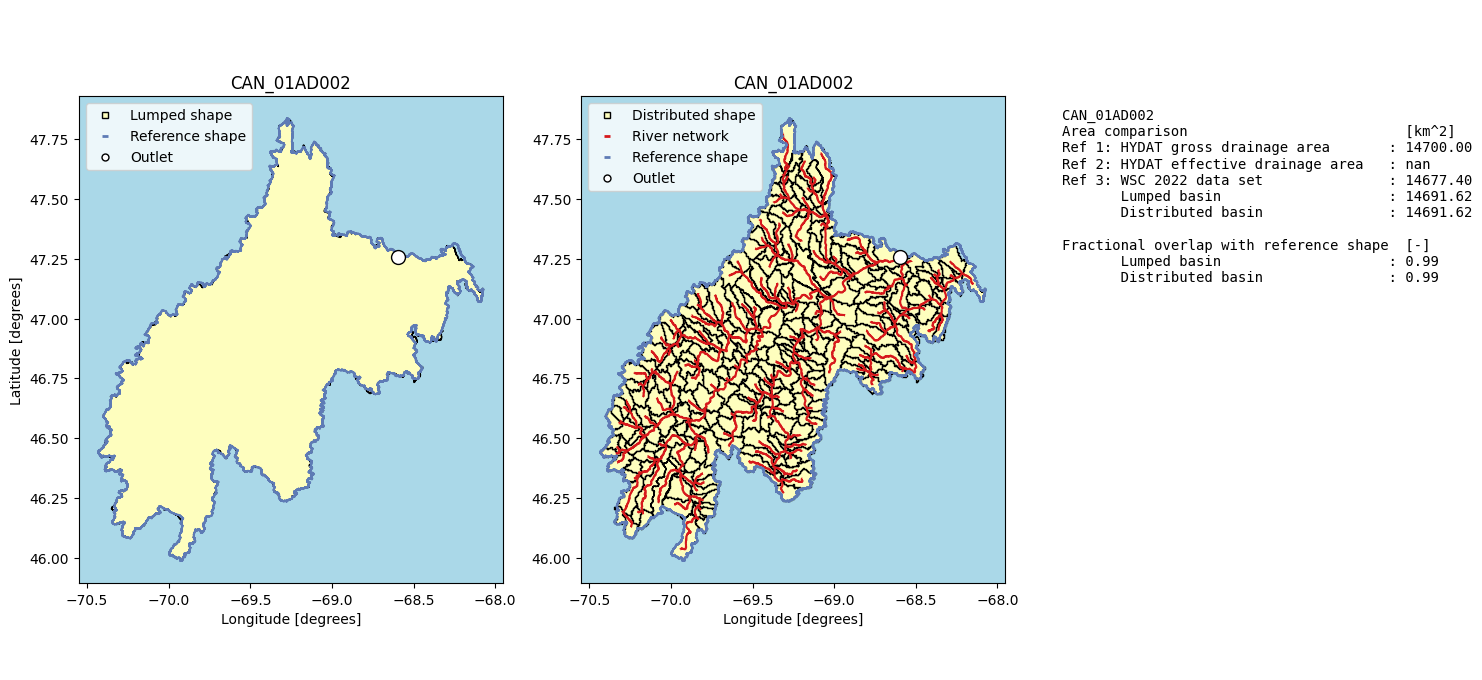

In [11]:
delineation_loop(0)

In [12]:
# Save the metadata file
cs_meta.to_csv(cs_meta_path / cs_meta_name, encoding='utf-8', index=False)

In [13]:
# Remove the temporary directory
shutil.rmtree(tmp_dir)